In [23]:
%load_ext autoreload
%autoreload 2
from methods2final import * 
sc.settings.verbosity = 3  
sc.settings.set_figure_params(dpi=160)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
adata = sc.read_h5ad("write/der20.h5ad")
adata

AnnData object with n_obs × n_vars = 4249 × 15086 
    obs: 'n_genes', 'n_counts', 'ID', 'cell'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_colors', 'pca'
    obsm: 'X_pca', 'X_tsne'
    varm: 'PCs'

In [6]:
batch_size = 128
dataset = torch.tensor(adata.X)
tensor_max_value = torch.max(dataset)
dataset = dataset/tensor_max_value
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [24]:
vae = VAE(image_size=15086)
if torch.cuda.is_available():
    print("Model on GPU")
    vae.cuda()
vae

Model on GPU


VAE(
  (encoder): Sequential(
    (0): Linear(in_features=15086, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=200, out_features=40, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=15086, bias=True)
    (3): Sigmoid()
  )
)

In [29]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
train(data_loader, vae, optimizer, batch_size, epochs=100)

Epoch[1/100] Loss: 265.983
Epoch[11/100] Loss: 256.717
Epoch[21/100] Loss: 263.444
Epoch[31/100] Loss: 261.182
Epoch[41/100] Loss: 259.839
Epoch[51/100] Loss: 263.379
Epoch[61/100] Loss: 261.514
Epoch[71/100] Loss: 264.865
Epoch[81/100] Loss: 281.418
Epoch[91/100] Loss: 255.871


In [30]:
rec_X = vae(to_var(dataset))
print(len(rec_X[0]))
rec_X = rec_X[0].data.cpu()

4249


In [31]:
X = (rec_X*tensor_max_value).detach().numpy()
X.shape

(4249, 15086)

In [32]:
adata.X = X

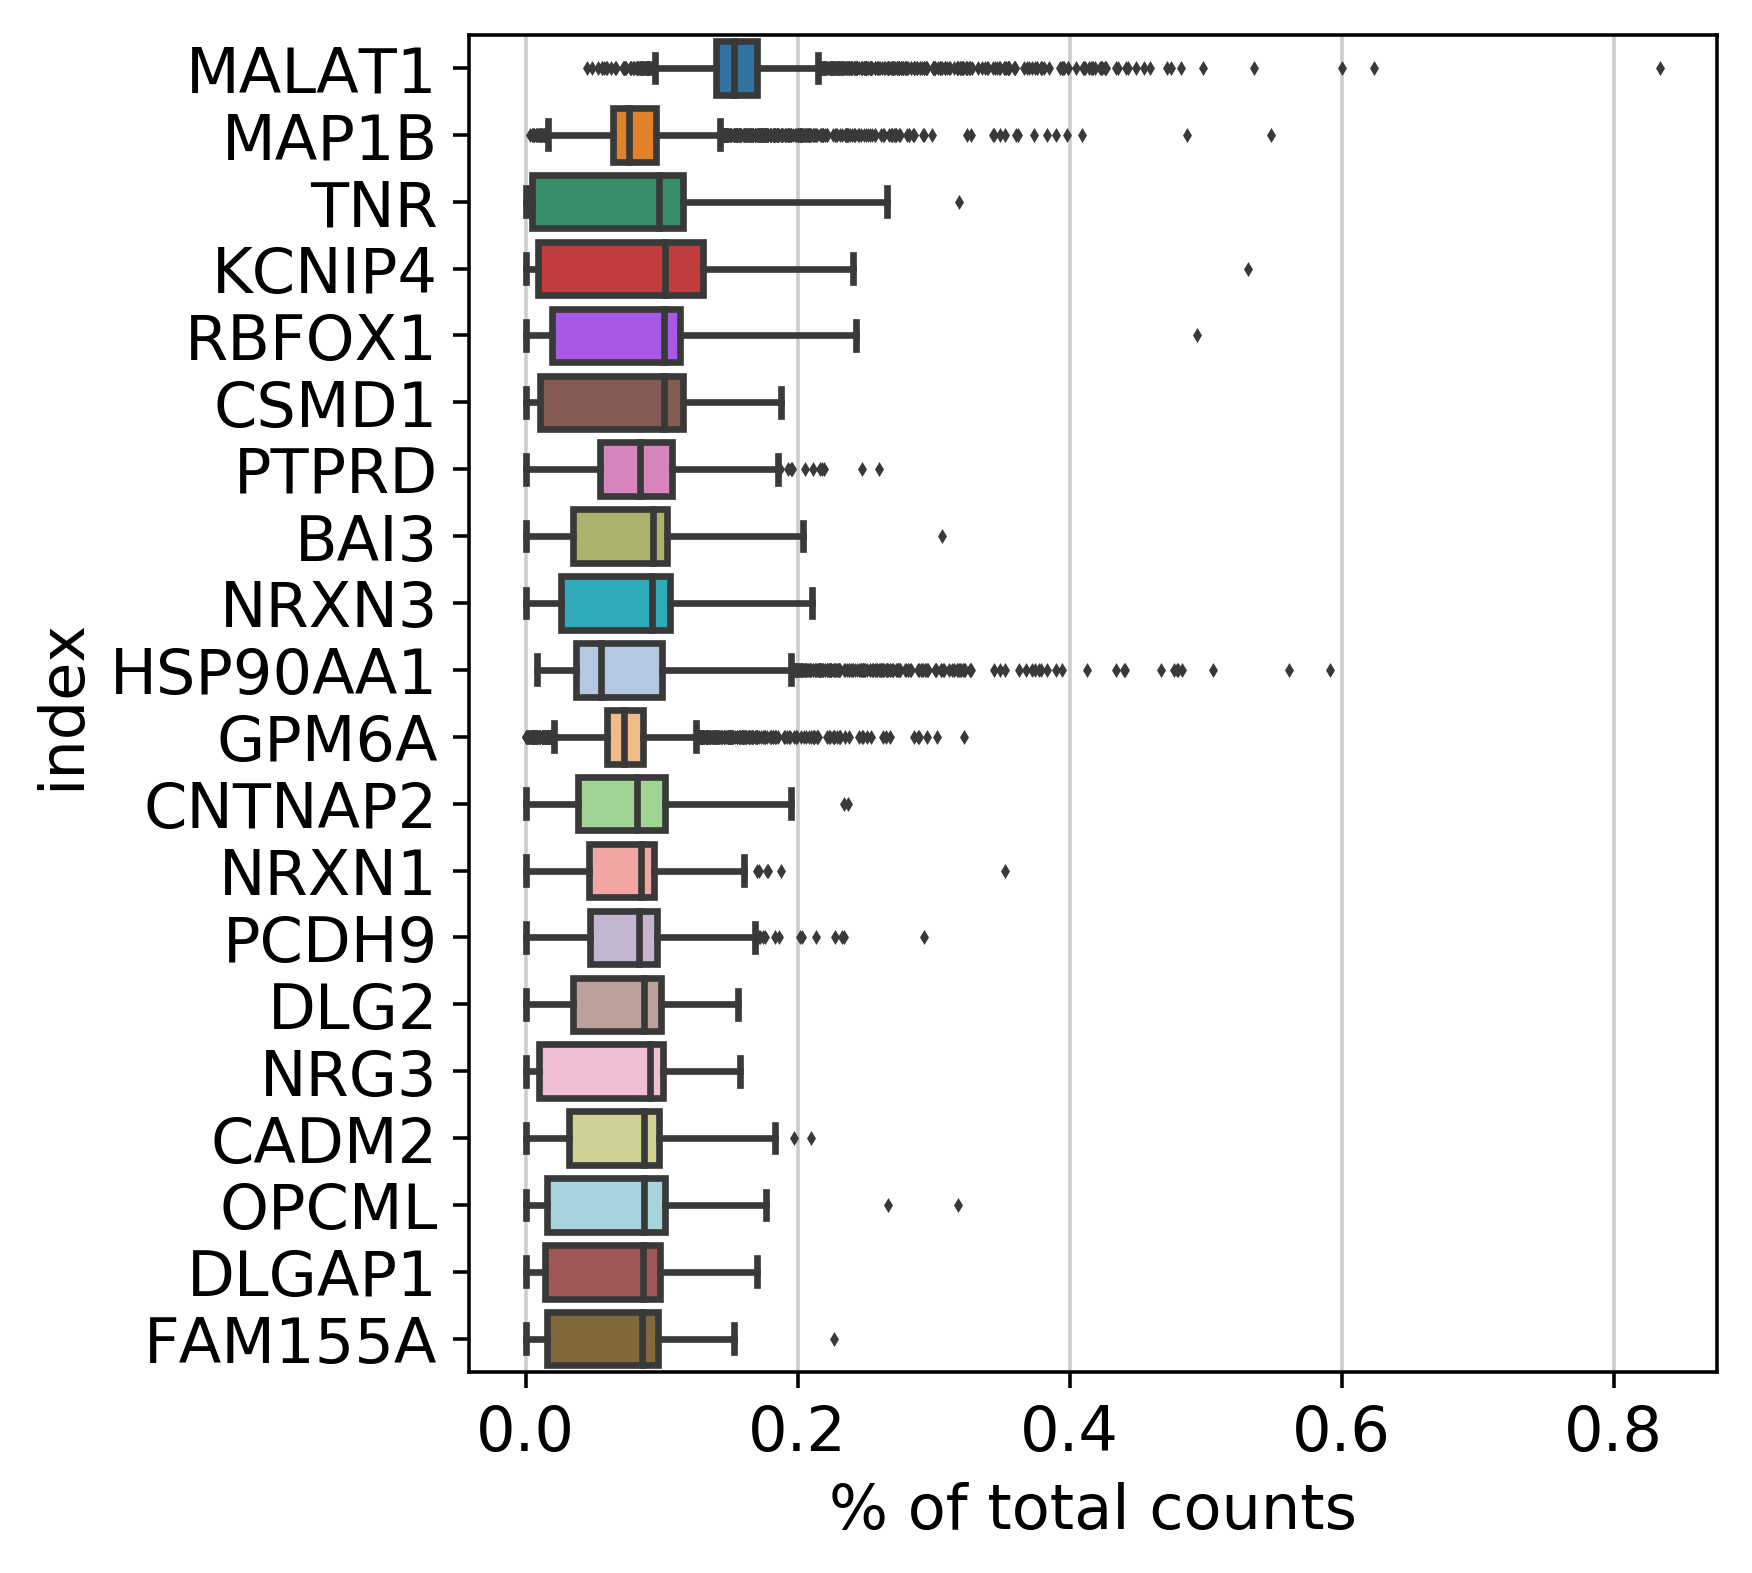

In [33]:
sc.pl.highest_expr_genes(adata, n_top=20)

computing PCA on highly variable genes


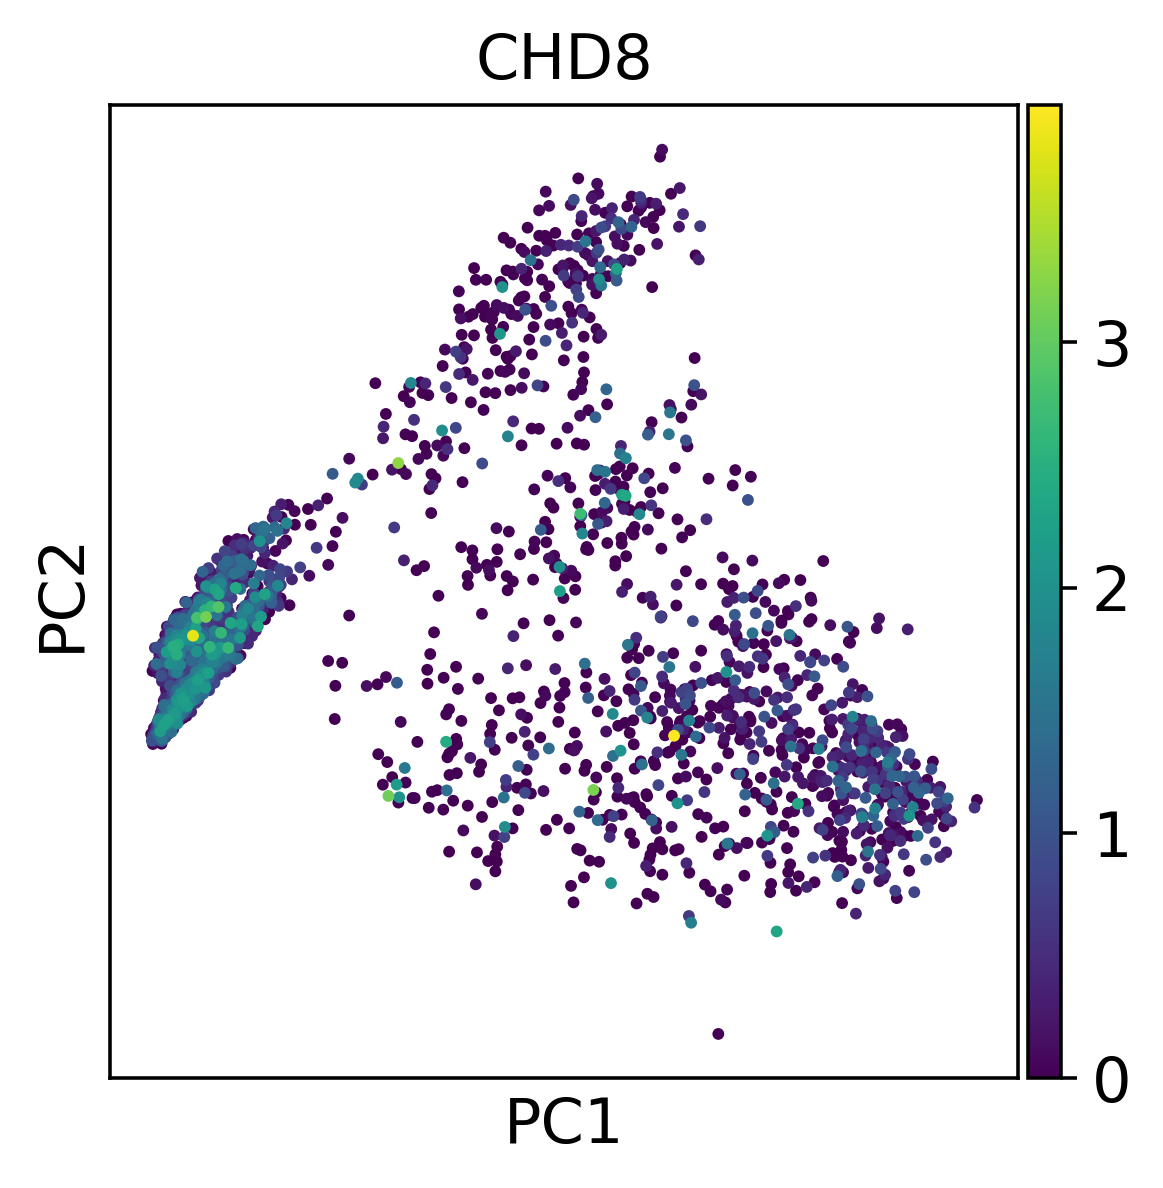

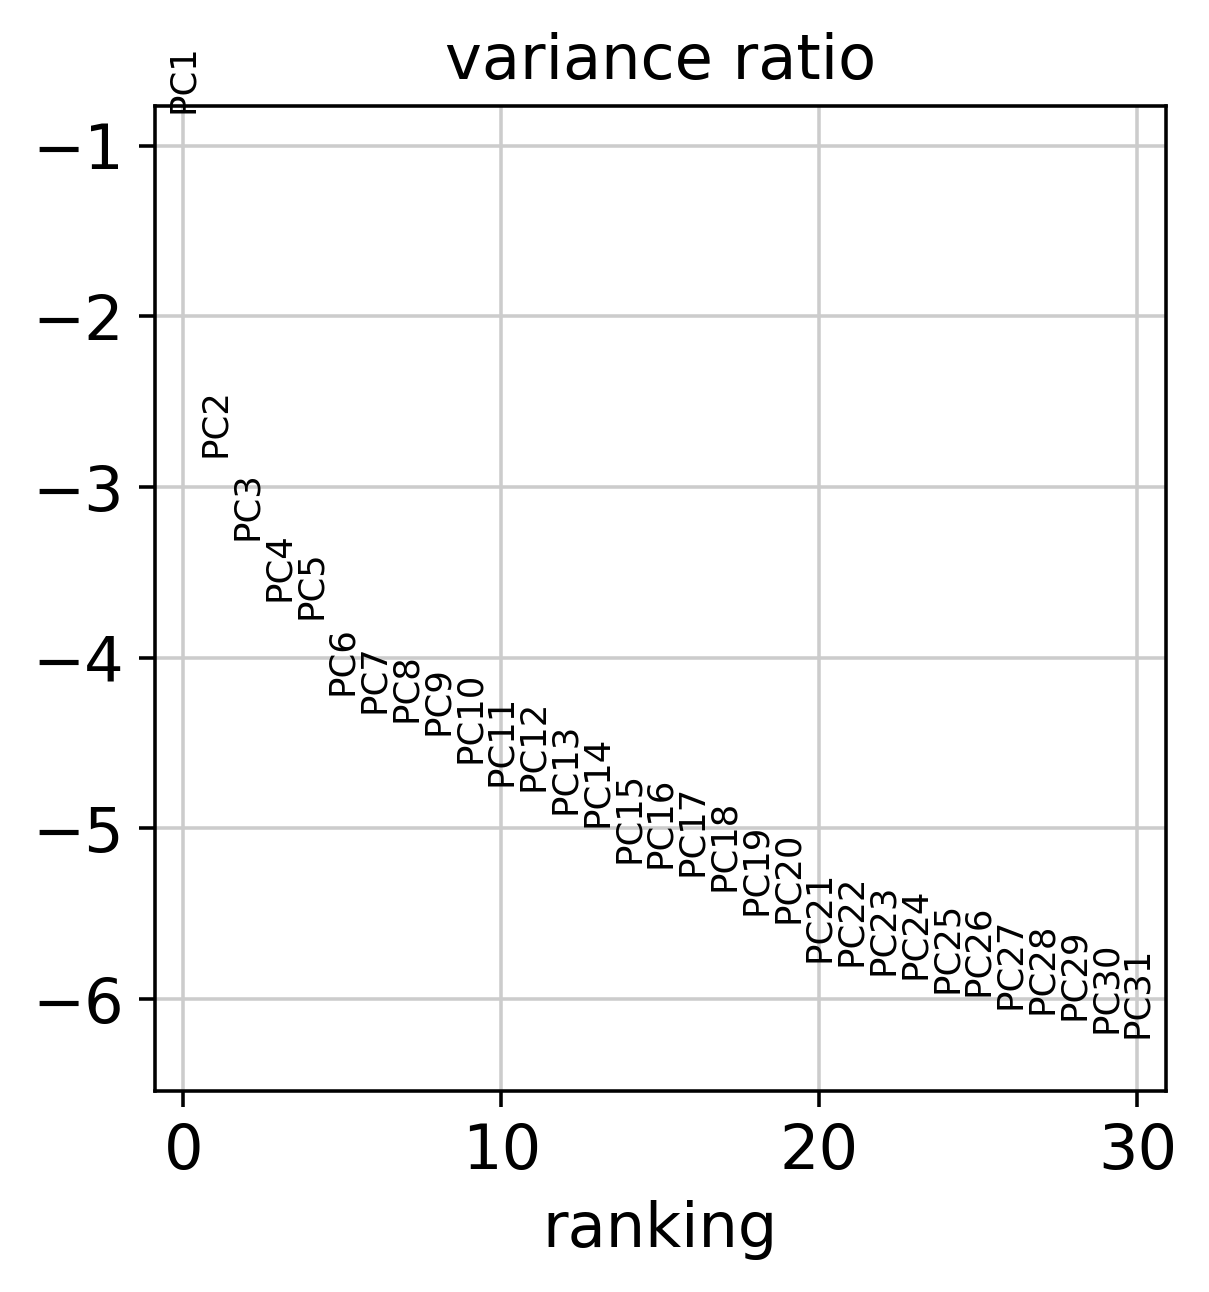

In [35]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='CHD8')
sc.pl.pca_variance_ratio(adata, log=True)

In [36]:
sc.tl.tsne(adata, use_rep='X_pca')

computing tSNE
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:15.27) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


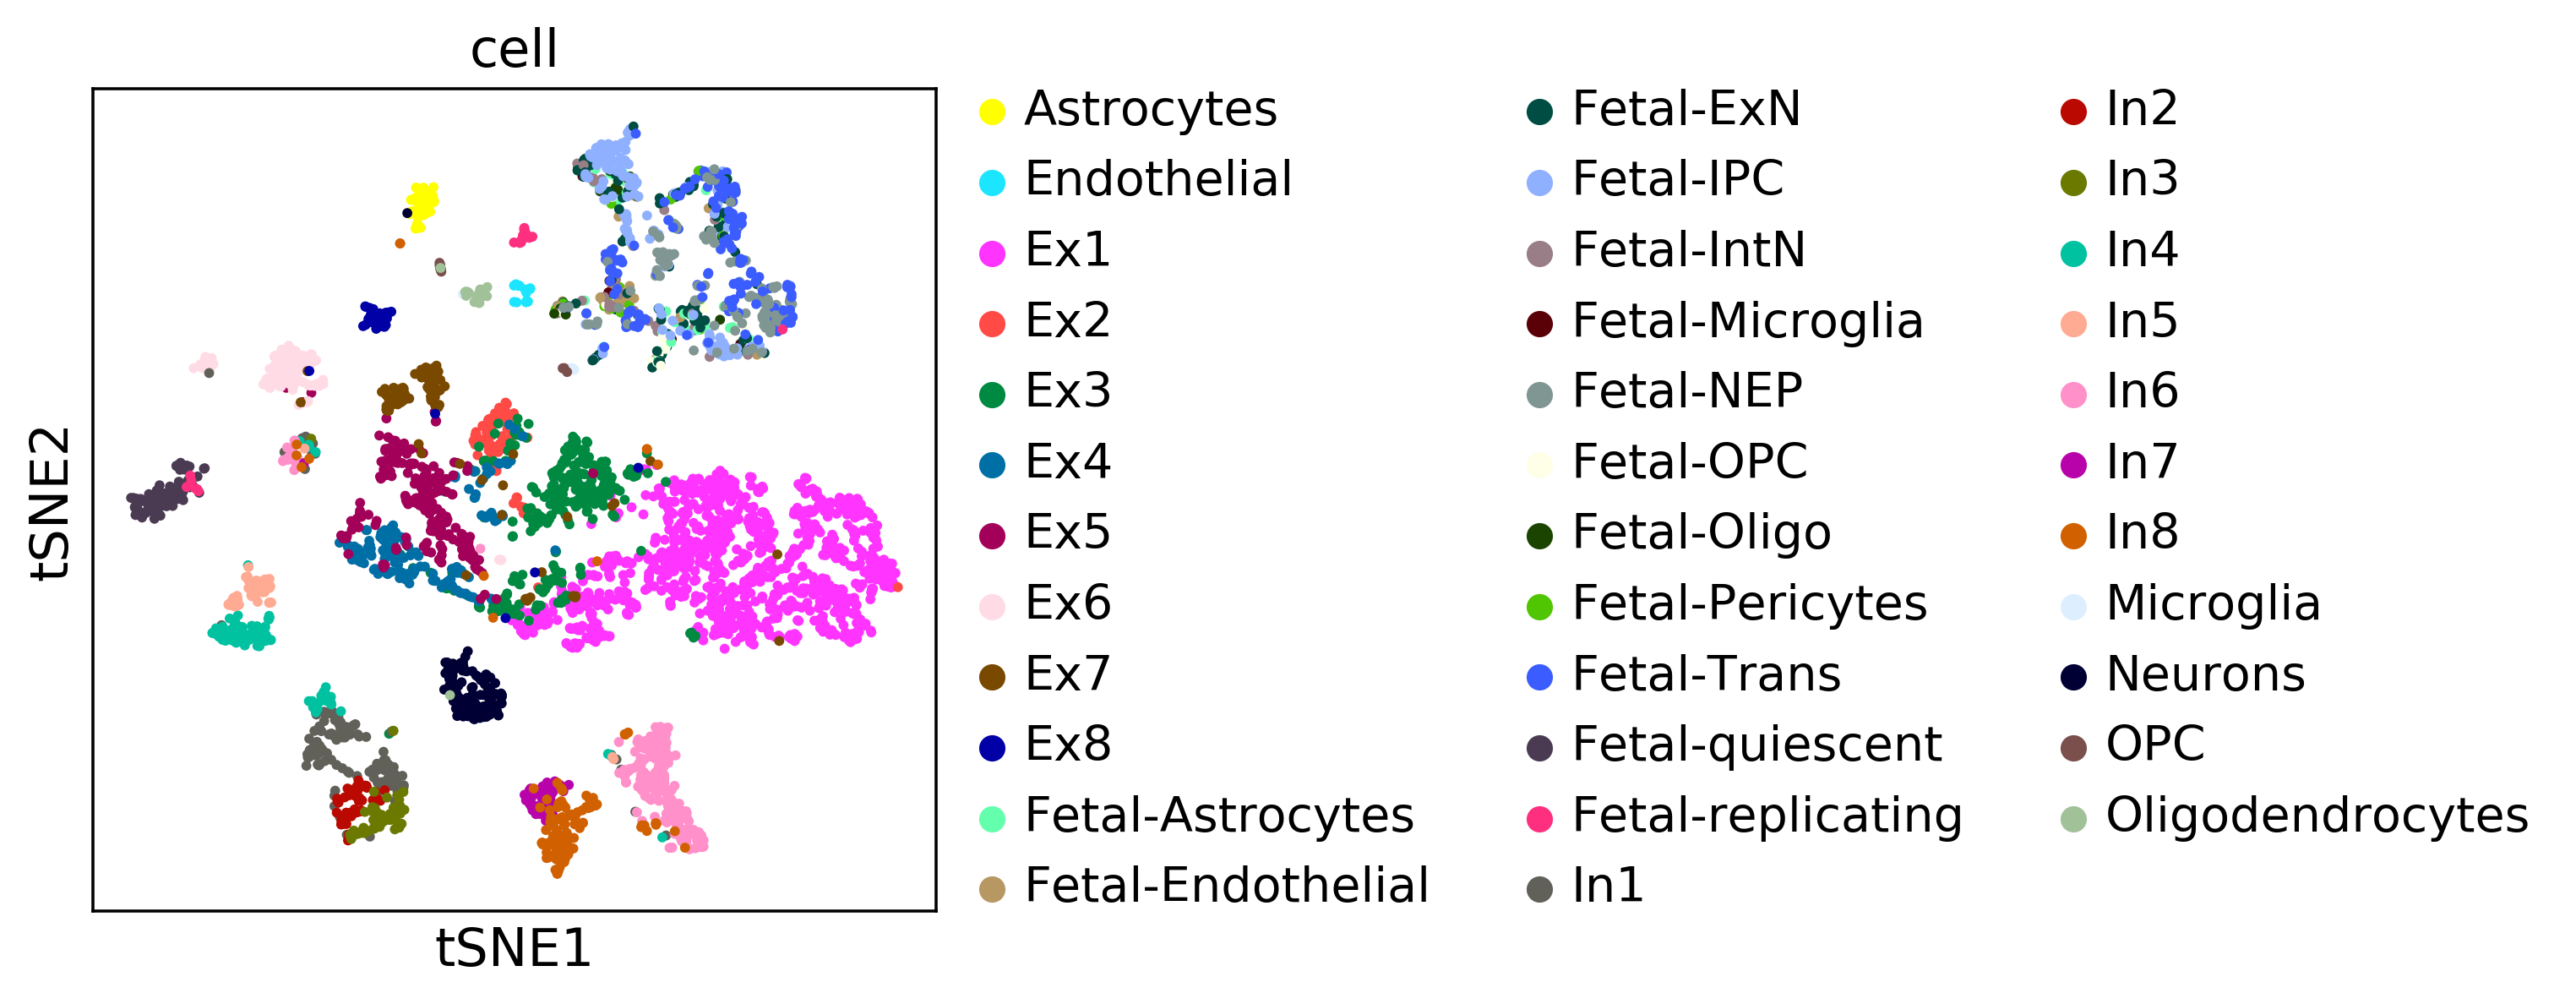

In [37]:
sc.pl.tsne(adata, color='cell')

In [38]:
codes = vae.encoder(to_var(dataset))
codes = codes.cpu().detach().numpy()
codes.shape

(4249, 40)

In [39]:
adata.obsm["X_code400"] = codes

In [40]:
sc.tl.tsne(adata, use_rep='X_code400')

computing tSNE
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:16.04) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


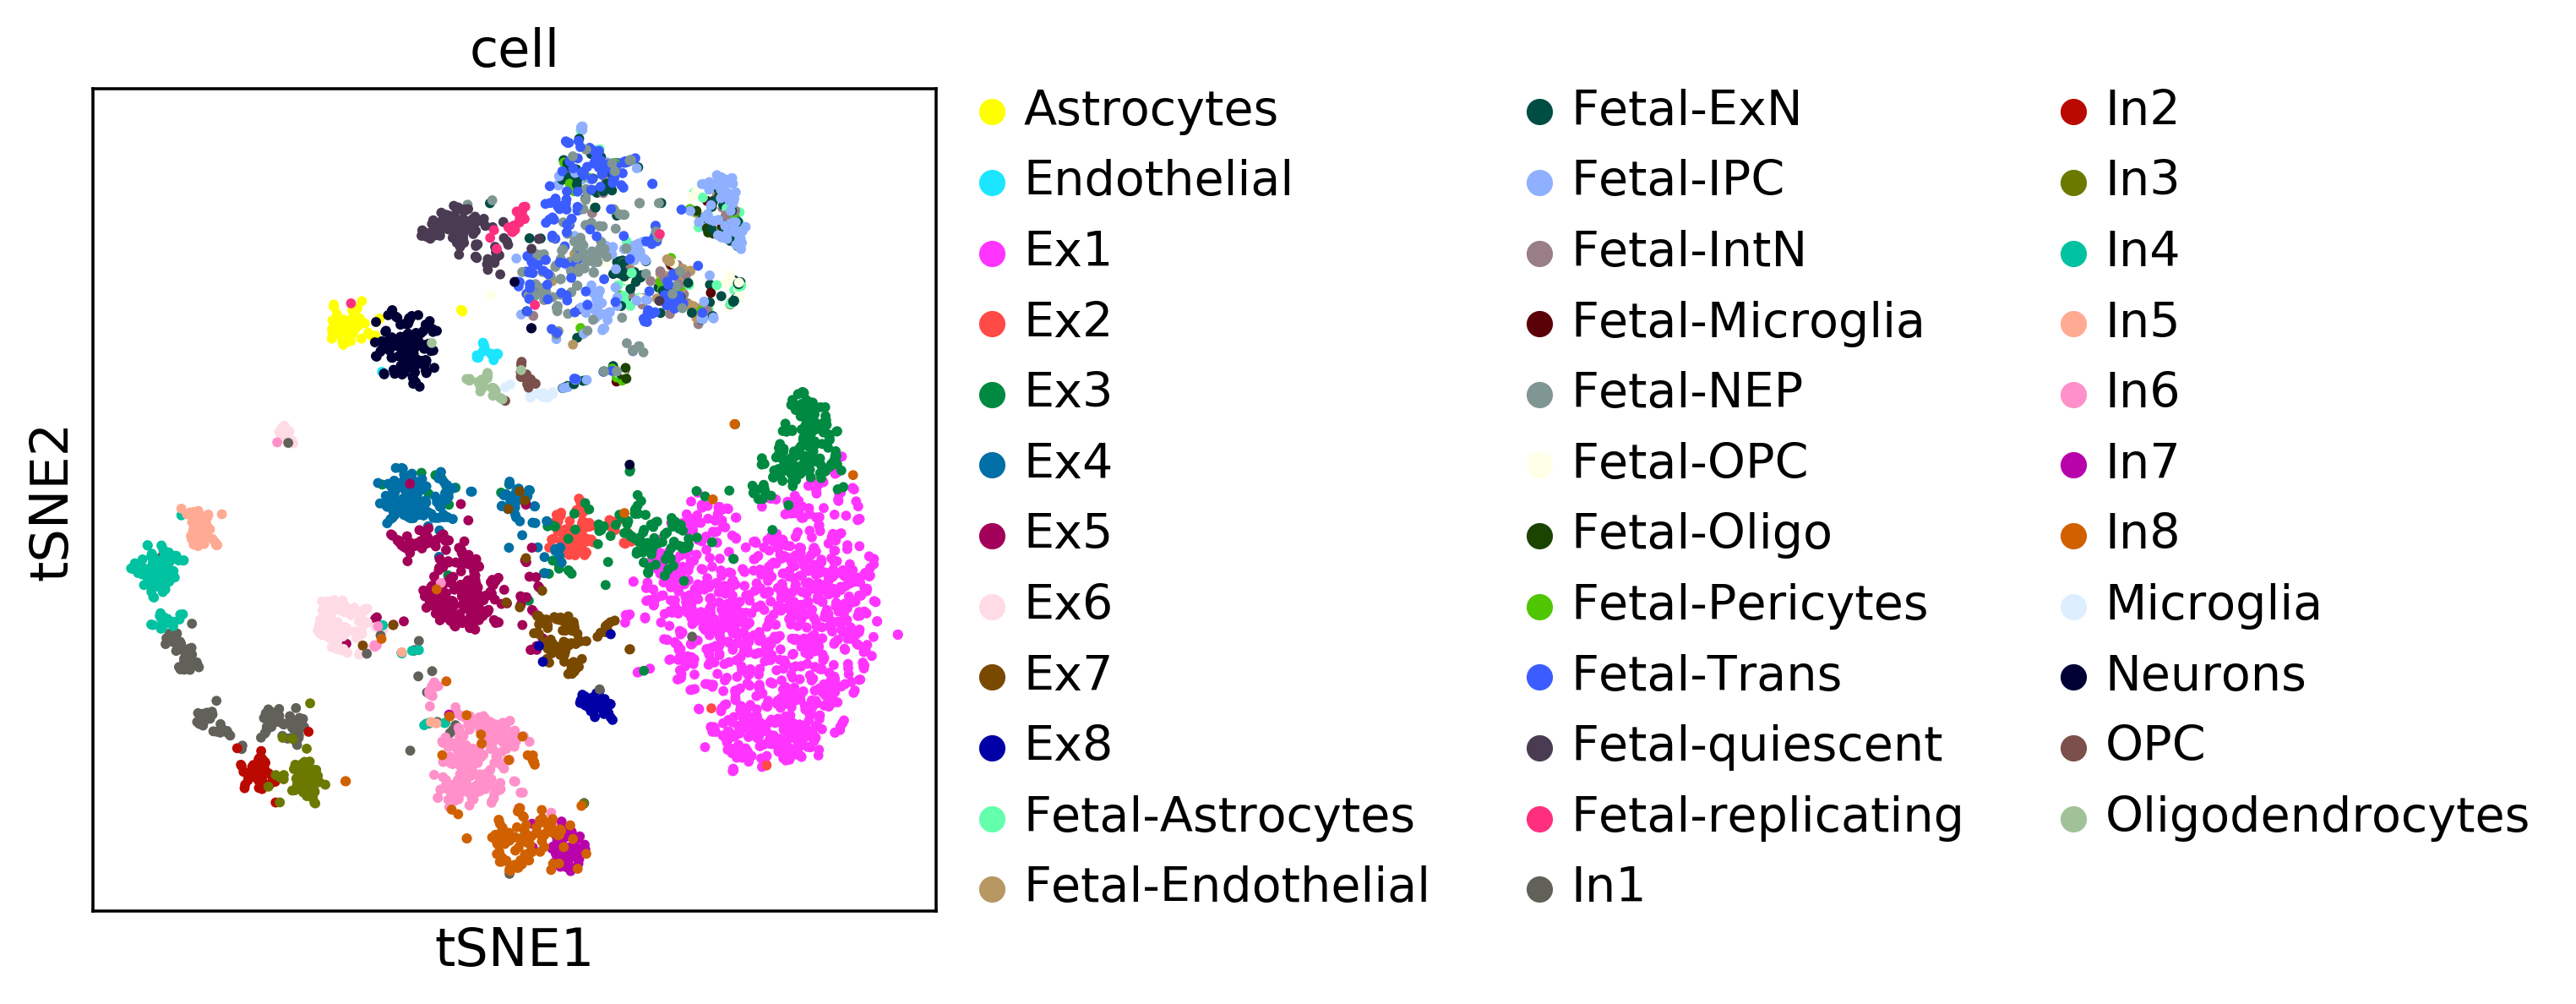

In [41]:
sc.pl.tsne(adata, color='cell')

In [1]:
sc.pl.highest_expr_genes(adata, n_top=20)

NameError: name 'sc' is not defined